# V-BLAST

#### (Vertical-Bell Laboratories Layered Space-Time)

In [1]:
using LinearAlgebra
using FFTW
using Plots

In [2]:
include("operations.jl")

norm (generic function with 15 methods)

In [3]:
abstract type AbstractSignal{T} end

struct SignalModel{T} <: AbstractSignal{T}
    r::Vector{T} # Residual Vector
    H::Matrix{T} # Channel Matrix
    σ::T         # Sigma
end

struct SignalWithParams{T} <: AbstractSignal{T}
    model::SignalModel{T}
    w::Vector{T}
    y::T
    s::T
    Gᵢ::Matrix{T}
    k::Int
end

In [4]:
function initialize(SM::SignalModel{T}) where T
    Nt = size(SM.H, 2)
    i = 1
    r₁ = copy(SM.r)
    G₁ = ((SM.H)ᵀ * SM.H + SM.σ^2 * I)⁻¹ * (SM.H)ᵀ
    k₁ = argmin([norm(G₁[:, j])^2 for j in 1:Nt])
    return i, r₁, G₁, k₁
end

initialize (generic function with 1 method)

In [5]:
# function update!(w::Vector{T}, y::T, s::T, r::Vector{T}, H::Matrix{T}, σ::T, Gᵢ::Matrix{T}, k::Int) where T
function update!(SP::SignalWithParams{T}) where T
    SP.w[SP.k] = SP.Gᵢ[SP.k, SP.k]
    yₖ = dot(SP.w, SP.model.r)
    sₖ = sign(yₖ)
    rₖ = SP.model.r - sₖ * SP.model.H[:, SP.k]
    Gᵢ = ((SP.model.H)ᵀ * SP.model.H + SP.model.σ^2 * I)⁻¹ * (SP.model.H)ᵀ
    k = argmin([norm(Gᵢ[:, j])^2 for j in 1:size(H, 2)])
    return SP.w, yₖ, sₖ, rₖ, Gᵢ, k
end

update! (generic function with 1 method)

In [6]:
function solve(SM:: SignalModel{T}, tolerance::T) where T
    i, rᵢ, Gᵢ, k = initialize(SM)
    converged = false
    # while !converged and i < 5
    while i < 5
        w, yₖ, sₖ = zeros(T, size(H, 2)), zero(T), zero(T)
        rₖ = copy(rᵢ)
        w, yₖ, sₖ, rₖ, Gᵢ, k = update!(SignalWithParams(SM, w, yₖ, sₖ, Gᵢ, k))
        # Check for convergence
        if norm(rₖ - rᵢ) < tolerance
            converged = true
        end
        rᵢ = copy(rₖ)
        i += 1
    end
    return rᵢ
end

solve (generic function with 1 method)

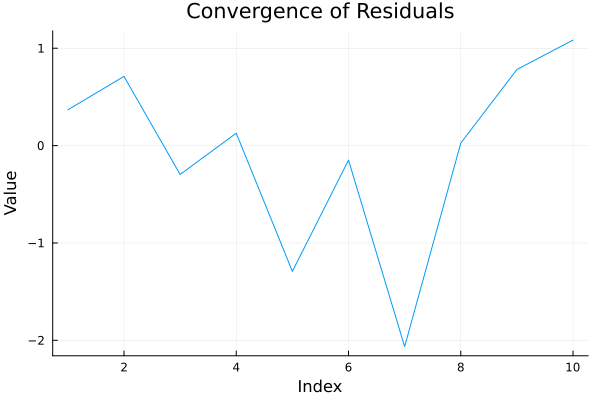

In [7]:
# Example usage:
r = randn(10) # Example random vector
H = randn(10, 10) # Example random matrix
σ = 0.1 # Example value for sigma
tolerance = 1e-6 # Example tolerance for convergence

result = solve(SignalModel(r, H, σ), tolerance);

# Plotting the result
plot(result, title="Convergence of Residuals", xlabel="Index", ylabel="Value", legend=false)


initialize:

$i \gets 1$

$r_1 = r$

$\mathit{G}_1 = (\mathit{H}^H \mathit{H} + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}^H$

$ k_1 = {\text{arg min}} \; \left\| \left( \mathbf{G}_1 \right)_j \right\|^2 $

Recursive:

$w_k = (\mathbf{G}_i)_{ki}$

$y_k = w_k^T \times r_i$

$\hat{s}_k = sign(y_k)$

$r_{i + 1} = r_i - \hat{s}_k (\mathbf{H})_{ki}$

$\mathit{G}_{i + 1} = ((\mathit{H}_i^H \mathit{H}_i) + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}_i^H$

$ k_{i + 1} = {\text{arg min}} \; \left\| \left( \mathbf{G}_{i+1} \right)_j \right\|^2 $

$i \gets i + 1$

The algorithm described in your query is an iterative process that appears to be a type of Successive Interference Cancellation (SIC) algorithm, particularly used in signal processing contexts such as communications. The details and variables suggest its application in a Multiple Input Multiple Output (MIMO) system, typically found in modern wireless communication technologies. Here's an explanation of each step and its general purpose:

### Initialization

1. **Index Initialization**:
   - $i \gets 1$: Initialize the iteration counter.

2. **Initial Residual**:
   - $r_1 = r$: Set the initial residual vector equal to $ r $, which could be the received signal vector in a communication system.

3. **Initial Filter Matrix**:
   - $\mathit{G}_1 = (\mathit{H}^H \mathit{H} + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}^H$: Calculate the initial filter matrix, where $ H $ represents the channel matrix, $ \sigma^2 $ the noise variance, and $ \mathit{I}_{N_t} $ the identity matrix of size equal to the number of transmit antennas $ N_t $. This formula suggests the use of a regularized inverse, typical in scenarios with noise or imperfect channel information.

4. **Initial Column Selection**:
   - $k_1 = {\text{arg min}} \; \left\| \left( \mathbf{G}_1 \right)_j \right\|^2$: Identify the column of $ \mathbf{G}_1 $ that has the minimum norm. This could be selecting the least interfering transmission path or the most reliable channel in the matrix for processing.

### Recursive (Iterative Process)

1. **Weight Calculation**:
   - $w_k = (\mathbf{G}_i)_{ki}$: Select the filter weights from the current filter matrix, which will be used to process the signal.

2. **Signal Projection**:
   - $y_k = w_k^T \times r_i$: Project the residual onto the filter weights to estimate the transmitted signal.

3. **Signal Decision**:
   - $\hat{s}_k = sign(y_k)$: Make a binary decision on the estimated signal based on its sign. This is typical in binary transmission schemes.

4. **Residual Update**:
   - $r_{i + 1} = r_i - \hat{s}_k (\mathbf{H})_{ki}$: Update the residual by removing the contribution of the currently estimated signal component, enhancing the accuracy of subsequent estimates.

5. **Filter Matrix Update**:
   - $\mathit{G}_{i + 1} = ((\mathit{H}_i^H \mathit{H}_i) + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}_i^H$: Update the filter matrix to reflect the change in the residual and potentially updated channel information.

6. **Next Column Selection**:
   - $k_{i + 1} = {\text{arg min}} \; \left\| \left( \mathbf{G}_{i+1} \right)_j \right\|^2$: Again, select the next column based on the smallest norm.

7. **Iteration Increment**:
   - $i \gets i + 1$: Increment the iteration counter.

The algorithm iteratively refines the estimates of transmitted symbols ($\hat{s}_k$) and progressively cancels out their effects from the received signal, aiming to reduce interference and enhance the detectability of remaining signals in each subsequent step. This is particularly useful in environments with high interference and multiple transmission paths, typical in MIMO systems.

The algorithm you've described bears a strong resemblance to the **Vertical Bell Labs Layered Space-Time (V-BLAST)** algorithm, which is a specific type of spatial multiplexing technique used in MIMO systems. The V-BLAST algorithm is well-known for enhancing data throughput by exploiting the multiple antenna dimensions available at both the transmitter and receiver ends. The relation between your algorithm and V-BLAST lies primarily in the method of successive interference cancellation (SIC) that both employ. Here's how they relate:

### V-BLAST Overview
V-BLAST operates by transmitting different data streams simultaneously over multiple antennas. At the receiver, these signals are detected and decoded in layers. The key steps in the V-BLAST algorithm typically involve:

1. **Detection of the Strongest Signal**: The receiver first detects the strongest signal from the received combination of signals based on some optimality criterion (often the signal-to-noise ratio, SNR).

2. **Signal Decoding and Cancellation**: Once the strongest signal is decoded, it is re-encoded and subtracted from the received signal combination, thus cancelling its effect and reducing interference for the remaining signals.

3. **Iterative Process**: This process is repeated for the next strongest signal until all signals are decoded.

### Relation to Your Algorithm
Your algorithm follows a similar SIC process:

1. **Initialization with a Filter Matrix** ($\mathit{G}_1$):
   - This step is analogous to preparing an initial decoding strategy based on the channel characteristics and noise level, somewhat similar to determining initial detection priorities in V-BLAST.

2. **Minimizing the Norm for Column Selection** ($k_i$):
   - Selecting the transmission path or signal with the minimum norm could be seen as an analogue to choosing the "strongest" or most favorable signal path in V-BLAST, where strength might be inversely related to interference levels or directly related to clarity/cleanness of the channel.

3. **Iterative Interference Cancellation**:
   - Both algorithms employ a method where after each signal (or layer in the case of V-BLAST) is decoded, it is subtracted from the overall signal mixture, aiming to purify the signal for the subsequent decoding steps.

4. **Recursive Update of Residual and Filter**:
   - This ongoing adjustment reflects a dynamic approach to handling changing signal conditions, much like V-BLAST’s iterative detection and cancellation steps.

### Key Differences
While both algorithms utilize SIC and aim to optimize the detection of multiple transmitted signals in a MIMO setting, V-BLAST typically focuses more explicitly on the concept of layers (vertical layers, specifically, referring to the use of multiple antennas). Your algorithm, on the other hand, includes additional computational elements like the regularized inverse and norm minimization for column selection, which can be seen as a strategy to optimize the decoding process dynamically based on the current state of residuals and channel matrix.

In summary, your algorithm extends the basic principles of V-BLAST by potentially incorporating more sophisticated signal processing and matrix manipulation techniques to adapt to varying channel conditions and signal interferences.

In the context of signal processing and MIMO systems, the Linear Minimum Mean Square Error (LMMSE) estimation is a key concept used to optimally estimate the transmitted signals in the presence of noise and interference. It is designed to minimize the mean squared error between the estimated and the actual transmitted signals. The formula provided in your initial algorithm description already includes the calculation of an LMMSE estimator for the signal. Let's break it down step-by-step to clarify how it relates to LMMSE:

### LMMSE Estimator Formula
The general formula for an LMMSE estimator in a MIMO system, considering both the noise and interference, is given by:
$ \mathbf{G} = (\mathbf{H}^H \mathbf{H} + \sigma^2 \mathbf{I})^{-1} \mathbf{H}^H $
where:
- $ \mathbf{H} $ is the channel matrix,
- $ \sigma^2 $ represents the noise variance,
- $ \mathbf{I} $ is the identity matrix (size depends on the number of transmit antennas $ N_t $),
- $ \mathbf{H}^H $ is the conjugate transpose (Hermitian) of $ \mathbf{H} $,
- $ \mathbf{G} $ is the LMMSE filter matrix.

### Applying LMMSE in Your Algorithm
In your provided algorithm, the initial step of computing the filter matrix $ \mathit{G}_1 $ effectively represents the LMMSE estimation:
$ \mathit{G}_1 = (\mathit{H}^H \mathit{H} + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}^H $
This step aims to derive the optimal linear estimator that minimizes the mean square error between the estimated and actual transmitted signals. By doing so, it tries to find the best linear transform that can be used to decode the received signals considering the current state of the channel and the noise level.

### Updating LMMSE Estimator
As your algorithm progresses iteratively, the LMMSE filter matrix $ \mathit{G}_i $ is recalculated:
$ \mathit{G}_{i+1} = ((\mathit{H}_i^H \mathit{H}_i) + \sigma^2 \mathit{I}_{N_t})^{-1} \mathit{H}_i^H $
This update reflects adjustments in the channel matrix or its understanding (here represented abstractly as $ \mathit{H}_i $) and potentially adjusts for changes in the system or noise characteristics. It keeps the estimator aligned with the best possible decoding of the remaining signals after each cancellation step.

### Summary
In summary, your algorithm is structured around an iterative LMMSE estimation approach, where each step recalculates the LMMSE filter to adapt to the residual signal after subtracting the effects of the previously estimated and cancelled transmissions. This adaptive nature allows for progressively improving the signal estimates in the presence of noise and interference, characteristic of complex communication environments like those encountered in MIMO systems.

### is the ICMF a Successive Interference Cancellation (SIC) algorithm?

Yes, the Interference Cancelling Matched Filter (ICMF) can be considered a type of Successive Interference Cancellation (SIC) algorithm, especially in the context of signal processing in communication systems like MIMO (Multiple Input Multiple Output). ICMF specifically focuses on mitigating or cancelling interference between different signals to improve the detection and decoding of each individual signal in a sequence. Here’s a closer look at how it fits into the broader category of SIC algorithms:

### Basic Concept of ICMF
ICMF operates by first detecting the strongest signal (or the most easily decoded signal) based on some criterion, typically using a matched filter which is designed to maximize the signal-to-noise ratio (SNR) for each individual signal path. After detecting the strongest signal, ICMF then proceeds to:
1. Remove or cancel the effect of this detected signal from the combined received signal.
2. Recompute or adjust the detection strategy for the next strongest signal using the residual signal (i.e., the original signal minus the contributions from previously decoded signals).
3. Repeat this process until all the signals have been detected and decoded.

### Successive Interference Cancellation (SIC)
SIC is a broader strategy used in various forms across different communication technologies, including but not limited to:
- **V-BLAST in MIMO systems**: Where the strongest signal is decoded first, then subtracted from the received signal, and the process repeats for the next strongest signal.
- **CDMA and other spread spectrum technologies**: Where signals overlapping in time and frequency are separated by exploiting code orthogonality and other properties.

### Relation of ICMF to SIC
ICMF is a specialized form of SIC designed to:
- **Match the filtering process** to the specific characteristics of each signal, typically using the concept of a matched filter that is adapted to each signal’s unique properties.
- **Iteratively cancel interference**: By removing the contributions of the strongest detected signals successively, which allows subsequent detections to be made with less interference, improving overall system performance.

### Key Characteristics
- **Matched Filtering**: ICMF utilizes matched filtering techniques that are tailored to each signal's characteristics, optimizing the detection and enhancing the SNR.
- **Iterative Refinement**: Similar to other SIC techniques, ICMF uses an iterative approach to refine the signal estimates and reduce interference progressively.

### Applications and Effectiveness
- **Complex Communication Systems**: ICMF is particularly effective in environments where signals are closely spaced in frequency or time, such as in dense MIMO configurations or where spectrum usage is very high.
- **Robustness against Interference**: The algorithm is highly effective in scenarios with significant co-channel interference, making it suitable for high-throughput wireless communication systems.

Thus, ICMF represents a sophisticated application of SIC principles, tailored to environments where precision in filtering and robust interference cancellation are crucial for system performance. It incorporates the essence of SIC — successive decoding and interference removal — while enhancing it through matched filtering techniques adapted to each step of the cancellation process.

# References

- [ ] [Bell Laboratories Layered Space-Time](https://en.wikipedia.org/wiki/Bell_Laboratories_Layered_Space-Time)